# Predicting Playing Cards

In [ ]:
import numpy as np
import os 
import PIL
import PIL.Image 
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt

In [2]:
local_data_dir = 'D:\card_data\cv_num_cards_deck\images'

In [3]:
img_height = 160
img_width = 160
img_size = (160, 160)
batch_size = 32

In [4]:
# Create the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    local_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width), # specified the resizing 
    batch_size=batch_size) 

Found 3594 files belonging to 3 classes.
Using 2876 files for training.


In [5]:
# Create the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    local_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3594 files belonging to 3 classes.
Using 718 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['1-13', '14-39', '40-52']


In [7]:
# visualize the first 9 images from the dataset
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [8]:
# image preprocessing 
normalization_layer = tf.keras.layers.Rescaling(1./127.5, offset=-1)
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
augmented_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x)), y))

In [9]:
# what does this do?
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Training our own Neural Network 

In [10]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255), # rescaling layer 
  tf.keras.layers.Conv2D(32, 3, activation='relu'), # relu activation function
  tf.keras.layers.MaxPooling2D(), # maxpooling layer 
  tf.keras.layers.Conv2D(32, 3, activation='relu'), # convolution layer  
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [11]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [12]:
model.fit(
  augmented_ds,
  validation_data=val_ds,
  epochs=2
)

Epoch 1/2
90/90 [==============================] - 13s 113ms/step - loss: 1.0967 - accuracy: 0.3745 - val_loss: 1.1529 - val_accuracy: 0.3886
Epoch 2/2
90/90 [==============================] - 9s 98ms/step - loss: 1.0946 - accuracy: 0.3745 - val_loss: 1.1465 - val_accuracy: 0.3816


## Assessing predictions from our model

In [13]:
def image_prediction(image_path):
    image = PIL.Image.open(image_path).resize((img_width, img_height))
    image_array = np.array(image) / 255.0  # Scale pixel values to 0-1
    image_array = np.expand_dims(image_array, axis=0)  # Add a batch dimension
    predictions = model.predict(image_array)
    probabilities = tf.nn.softmax(predictions[0])  # Apply softmax to convert logits to probabilities
    predicted_class = np.argmax(probabilities)  # Get the index of the highest probability
    print(f"Predicted class: {predicted_class}, Probability: {probabilities[predicted_class]}")

In [14]:
image_prediction('test_images/A.JPG')
image_prediction('test_images/52b.JPG')
image_prediction('test_images/39.JPG')

1/1 [==============================] - 0s 134ms/step
Predicted class: 0, Probability: 0.37011754512786865
1/1 [==============================] - 0s 18ms/step
Predicted class: 0, Probability: 0.37011754512786865
1/1 [==============================] - 0s 18ms/step
Predicted class: 0, Probability: 0.37011754512786865


Our model is assessing all three classes as the same class with very similar probability.

# Transfer Learning with ImageNet

In [15]:
IMG_SHAPE = img_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [16]:
base_model.trainable = False

In [17]:
image_batch, label_batch = next(iter(augmented_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


(32, 1280)

In [19]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
# x = preprocess_input(x) # inputs are already preprocessed
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

23/23 [==============================] - 1s 19ms/step - loss: 0.6245 - accuracy: 0.3384


In [28]:
history = model.fit(augmented_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
90/90 [==============================] - 21s 193ms/step - loss: 0.7887 - accuracy: 0.3352 - val_loss: 0.2163 - val_accuracy: 0.3301
Epoch 2/10
90/90 [==============================] - 18s 196ms/step - loss: 0.3348 - accuracy: 0.3310 - val_loss: 0.2227 - val_accuracy: 0.3301
Epoch 3/10
90/90 [==============================] - 18s 201ms/step - loss: 0.2157 - accuracy: 0.3334 - val_loss: 0.2195 - val_accuracy: 0.3301
Epoch 4/10
90/90 [==============================] - 18s 197ms/step - loss: 0.1326 - accuracy: 0.3380 - val_loss: 0.2128 - val_accuracy: 0.3301
Epoch 5/10
90/90 [==============================] - 18s 200ms/step - loss: 0.0692 - accuracy: 0.3369 - val_loss: 0.2079 - val_accuracy: 0.3301
Epoch 6/10
90/90 [==============================] - 18s 201ms/step - loss: -0.0073 - accuracy: 0.3453 - val_loss: 0.2021 - val_accuracy: 0.3301
Epoch 7/10
90/90 [==============================] - 19s 204ms/step - loss: -0.0862 - accuracy: 0.3453 - val_loss: 0.1975 - val_accuracy: 0.33

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [2 2 1 1 2 0 1 0 2 0 2 2 2 1 1 1 1 0 0 2 0 0 2 1 1 1 2 1 0 1 1 1]


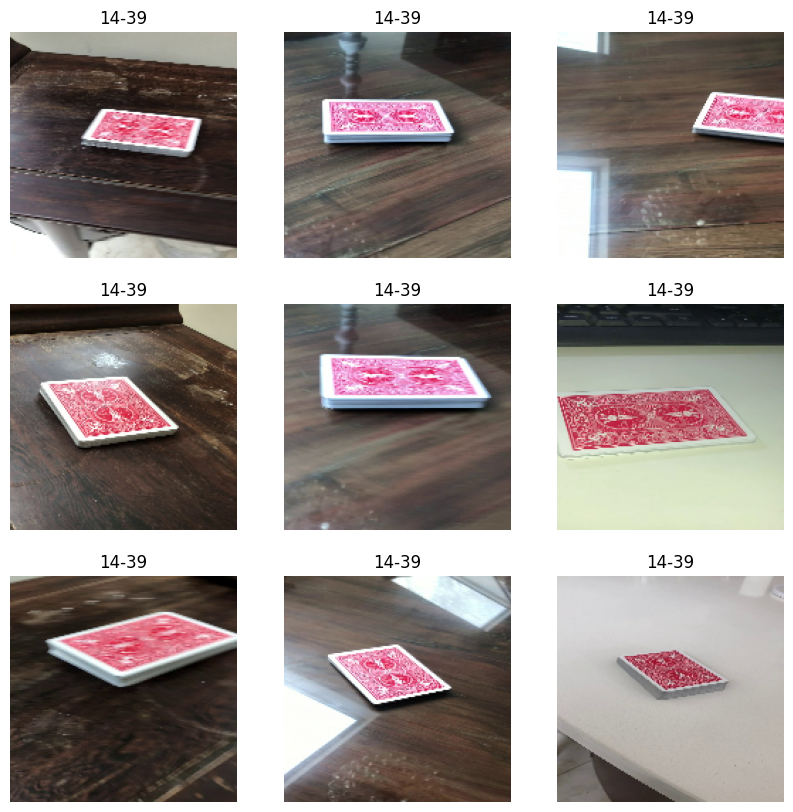

In [31]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")